In [6]:
from datasets import load_dataset
from torchvision import transforms
import json
"""
Parameters:

- datset_name: also include train/test split

- hf_dataset: the dataset identifier in huggingface;

- optimized_dir: directory to save optimized_dataset;

- image_key: "webp", "jpg" or "png";

- id_key: the id attribute in dataset card, default is "__key__"

- label_key: the text/caption attribute in dataset card, default is "cls" 

- threshold(inclusive): the maximum distance for search results, in hamming distance, how many bits in the hash string is different.

- perceptual hash or average hash

- k: the number of results to show

NOTE: need to provicde classes as a list if labels are numerical ELSE LEFT THE CLASSES LIST EMPTY
"""

dataset_name = "cub"
split = "test"

threshold = 4
method = "perceptual" 

k = 5

"""LEFT CLASSES LIST EMPTY IF NO NEED TO PROVIDE IT"""
classes = json.load(open(f"data/classes_{dataset_name}.json", "r"))
print(len(classes))

200


In [7]:
if dataset_name == "cifar100":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-cifar100", split=split, streaming=False)
elif dataset_name == "caltech101":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-caltech101", split=split, streaming=False)
elif dataset_name == "food101":
    hf_dataset = load_dataset("clip-benchmark/wds_food101", split=split, streaming=False)
elif dataset_name == "cars":
    hf_dataset = load_dataset("clip-benchmark/wds_cars", split=split, streaming=False)
elif dataset_name == "country211":
    hf_dataset = load_dataset("clip-benchmark/wds_country211", split=split, streaming=False)
elif dataset_name == "sun397":
    hf_dataset = load_dataset("clip-benchmark/wds_sun397", split=split, streaming=False)
elif dataset_name == "fer2013":
    hf_dataset = load_dataset("clip-benchmark/wds_fer2013", split=split, streaming=False)
elif dataset_name == "aircraft":
    hf_dataset = load_dataset("clip-benchmark/wds_fgvc_aircraft", split=split, streaming=False)
elif dataset_name == "imagenetv2":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenetv2", split=split, streaming=False)
elif dataset_name == "imagenet-o":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-o", split=split, streaming=False)
elif dataset_name == "pets":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-pets", split=split, streaming=False)
elif dataset_name == "imagenet-a":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-a", split=split, streaming=False)
elif dataset_name == "imagenet-r":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-r", split=split, streaming=False)
elif dataset_name == "cub":
    hf_dataset = load_dataset("lxs784/cub-200-2011-clip-benchmark", split=split, streaming=False)

if "webp" in hf_dataset[0] and hf_dataset[0]["webp"] is not None:
    image_key = "webp"
elif hf_dataset[0]["jpg"] is not None:
    image_key = "jpg"
    
dataset_name += "-" + split
print(dataset_name)

cub-test


# Load dataset from Huggingface

Optimize hf dataset for fast search and retrival.

In [8]:
import os
import json
from pathlib import Path
from PIL import Image
from tqdm import tqdm

def optimize_hf_to_lightning(hf_dataset, output_dir, image_key="webp", id_key="__key__", label_key="cls"):
    """
    Iterates over the Hugging Face dataset and saves each sample to disk in a format
    that Lightning's StreamingDataset can read. An index file (index.json) is created.
    
    Each sample is stored as:
      - An image file in JPEG format
      - A metadata entry in the index that records the file path and label
    
    Parameters:
      hf_dataset: The Hugging Face dataset (can be streaming or in-memory)
      output_dir: Directory where the optimized dataset will be stored.
      image_key: Field name in the dataset containing image data.
      id_key: Field name to use as a unique identifier.
      label_key: Field name containing label or class information.
    Returns:
      The output directory path (which contains the data and index).
    """

    os.makedirs(output_dir, exist_ok=True)
    index = {}
    # serializer = JPEGSerializer()  # Can be used to serialize images if desired.
    
    # Iterate over the dataset and write each sample.
    for sample in tqdm(hf_dataset):
        uid = sample[id_key]
        # Define a file path for the image.
        image_filename = f"{uid}.png"
        image_path = os.path.join(output_dir, image_filename)
        
        # Get the image. Depending on your dataset, it might already be a PIL Image.
        image = sample[image_key]
        if not isinstance(image, Image.Image):
            # If image is not a PIL image, try converting it.
            image = Image.fromarray(image)
            
        if image.mode != "RGB":
            image = image.convert("RGB")
        # Save the image in JPEG format.
        image.save(image_path, format="PNG")
        
        # Record metadata in the index.
        index[uid] = {
            "image_path": image_filename,  # Store relative path
            "label": sample[label_key],
        }
    
    # Write out the index file.
    index_path = os.path.join(output_dir, "index.json")
    with open(index_path, "w") as f:
        json.dump(index, f)
    
    return output_dir

In [9]:
import os
import io
import json
from PIL import Image
import imagehash
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class HFDataset(Dataset):

    def __init__(self, root_dir, index_file, lookup=None, transform=None):
        self.root_dir = root_dir
        with open(os.path.join(root_dir, index_file), "r") as f:
            self.index_data = json.load(f)
        self.lookup = lookup
        self.samples = list(self.index_data.items())
        self.uid_to_sample = dict(self.samples)
        self.transform = transform 

    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, index):
        uid, sample = self.samples[index]
        image_path = os.path.join(self.root_dir, sample["image_path"])
        pil_image = Image.open(image_path).convert("RGB")
        text = self.lookup[sample["label"]] if self.lookup else sample["label"]

        ahash = str(imagehash.average_hash(pil_image))
        phash = str(imagehash.phash(pil_image))

        return index, text, ahash, phash, uid

    def get_by_id(self, uid):
        """
        Retrieve a raw PIL image and metadata by its unique identifier.
        """
        # if uid not in self.uid_to_sample:
        #     raise KeyError(f"UID: {uid} not found in dataset.")
        sample = self.uid_to_sample[uid]
        image_path = os.path.join(self.root_dir, sample["image_path"])
        pil_image = Image.open(image_path).convert("RGB")
        text = self.lookup[sample["label"]] if self.lookup else sample["label"]
        ahash = imagehash.average_hash(pil_image)
        phash = imagehash.phash(pil_image)

        return pil_image, text, ahash, phash

  0%|          | 0/5794 [00:00<?, ?it/s]

100%|██████████| 5794/5794 [07:26<00:00, 12.97it/s]


('Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Laysan Albatross', 'Laysan Albatross') ('ffefcf67c3f3c985', '1f1ff8f7171f0303', 'fff7e4e440c8cdff', 'f8f3e707c1e7cfff', 'ffbf9fcf631fde58', 'fffff3f1e0e6cccc', 'ffffc3e3c3cfcff3', 'ffef83e7f2f0c3c3', '42008bd8c5c3e1ef'

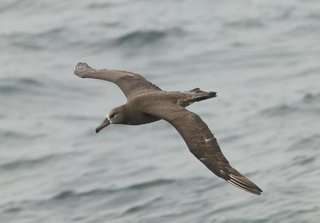

In [10]:
optimized_dir = f"data/optimized_dataset/{dataset_name}"

if not os.path.exists(os.path.join(optimized_dir, "index.json")):
    optimize_hf_to_lightning(hf_dataset, optimized_dir, image_key=image_key)

dataset = HFDataset(
        index_file = "index.json",
        root_dir=optimized_dir,
        lookup=classes if classes else None,
        # transform = transform
        )

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
for _, texts, ahashes, phashes, uids in dataloader:
    print(texts, ahashes, phashes, uids)
    break
sample_uid = dataset.samples[0][0]
pil_image, text, ahash, phash = dataset.get_by_id(sample_uid)
pil_image.show()

# Find duplicate images between your dataset and laion400m
in this step, we load the pre-computed binary index for laiion, 

for each image in your dataset, it will compute its hash value, and find the images in laion that has similar value.

Currently, the perceptual hash is applied for hash value match, the average match will be available in the future.

Parameters:

- threshold(inclusive): the maximum distance for search results, in hamming distance, how many bits in the hash string is different.
- perceptual hash or average hash

In [6]:
import pandas as pd
import faiss
import numpy as np

# if method == "perceptual":
binary_index_phash = faiss.read_index_binary("lightning_binary_index.bin")
# if method == "average":
#     binary_index_ahash = faiss.read_index_binary("lightning_binary_index_average_hash.bin")

In [7]:
"""
Make the {uid: match_indices} pairs
"""
def hex_to_vector(hex_str, vector_dim=16):
    """
    Convert a 16-character hex string to a 64-bit binary vector. 
    Each hex digit is converted to a 4-bit binary number.
    Ensure the hex string is exactly 16 characters long and binary vector is exactly 64 bits long.
    """
    if hex_str is None:
        return [0] * vector_dim * 4

    if len(hex_str) != vector_dim:
        raise ValueError(f"Hex string length ({len(hex_str)}) does not match expected dimension ({vector_dim}).")
    
    vector = []
    for digit in hex_str:
        if digit not in "0123456789abcdef":
            raise ValueError("Invalid hex string")

        binary_str = bin(int(digit, 16))[2:].zfill(4)
        vector.extend([int(bit) for bit in binary_str])

    if len(vector) != vector_dim * 4:
        raise ValueError("Hex string did not convert to the expected number of bits")
    return vector

In [ ]:
from tqdm import tqdm
results = {}
part = 0
json_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/match_indices_{threshold}"
os.makedirs(json_dir, exist_ok=True)

for i, (_, texts, ahashes, phashes, uids) in enumerate(tqdm(dataloader, desc=f"Finding duplicates in {dataset_name}")):
    query_vectors = np.array([hex_to_vector(x, 16) for x in phashes], dtype='uint8')
    queries_packed = np.packbits(query_vectors, axis=1).reshape(len(phashes), 8)

    lims, D_range, I_range = binary_index_phash.range_search(queries_packed, threshold)

    for q in range(queries_packed.shape[0]):
        start = lims[q]
        end = lims[q + 1]
        if start == end:
            continue
        match_indices = I_range[start:end].tolist()
        if len(match_indices) > 0:
            results[uids[q]] = match_indices
        if len(results) == 100:
            with open(os.path.join(json_dir, f"results_{part}.json"), "w") as f:
                json.dump(results, f)
                tqdm.write(f"part {part} saved!")
            results = {} # reset
            part += 1
            
if len(results) > 0:
    with open(os.path.join(json_dir, f"results_{part}.json"), "w") as f:
        json.dump(results, f)

In [ ]:
"""extra step: put all results in one json"""
import glob
import os
json_files = glob.glob(os.path.join(json_dir, "*.json"))

results = {}
for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)
    results.update(data)

with open(os.path.join(json_dir, "combined_results.json"), "w") as f:
    json.dump(results, f)
print(f"Combined results saved to {os.path.join(json_dir, 'combined_results.json')}, total duplicate images: {len(results)}")

# Load the laion400m dataset

In [15]:
"""load the laion400m dataset for image retrival"""
import os
from lightning_cloud.utils.data_connection import add_s3_connection
from lightning.data import StreamingDataset, StreamingDataLoader
from lightning.data.streaming.serializers import JPEGSerializer
import torchvision.transforms.v2 as T
from tqdm import tqdm
import imagehash
import torchvision.transforms as T
import matplotlib.pyplot as plt 
import numpy as np
import torch
import json
import concurrent
from PIL import Image
import io

# 1. Add the prepared dataset to your teamspace
add_s3_connection("laoin-400m")

# 2. Create the streaming dataset
class LAOINStreamingDataset(StreamingDataset):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.serializer = JPEGSerializer()

    def __getitem__(self, index):
        id, image, text, _, _, _ = super().__getitem__(index)
        
        return Image.open(io.BytesIO(image)), text, str(id)

laion = LAOINStreamingDataset(input_dir="/teamspace/s3_connections/laoin-400m")

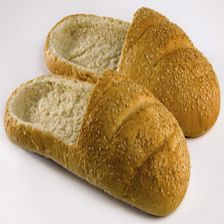

In [16]:
laion[69815173][0]

# Visualize Results

Plot images for the results collected from last step

Parameter:
- k: show top-k results

In [17]:
"""
plot original image and overlap images
one row per plot
"""
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import textwrap
import json
import imagehash

def resize_image(image, target_size=(256, 256)):
    return image.resize(target_size, Image.Resampling.LANCZOS)

def show_match_results_single(dataset, results, output_dir, k=5):
    cols = k + 2
    for uid, match_indices in tqdm(results.items(), desc=f"plotting duplicate images for {dataset_name}"):
        fig, axes = plt.subplots(1, cols, figsize=(cols * 3, 3))
        axes[0].text(0.5, 0.5, uid, fontsize=24, ha='center', va='center')
        axes[0].axis("off")

        original_image, original_text, ahash, phash= dataset.get_by_id(uid)
        original_image_resized = resize_image(original_image)
        axes[1].imshow(original_image_resized)
        wrapped_caption = "\n".join(textwrap.wrap(original_text, width=24))
        axes[1].set_title(wrapped_caption)
        axes[1].axis('off')

        for j in range (k):
            ax = axes[j + 2]
            if j >= len(match_indices):
                ax.imshow(np.ones((1, 1, 3)))
            else:
                idx = match_indices[j]
                match_image, match_text, _ = laion[idx]
                laion_phash = imagehash.phash(match_image)
                p_dist = abs(phash - laion_phash)
                ax.imshow(match_image)
                caption_match = "p_dist: " + str(p_dist) + " " + match_text
                wrapped_lines = textwrap.wrap(caption_match, width=24)
                wrapped_caption_match = "\n".join(wrapped_lines[:2])
                ax.set_title(wrapped_caption_match, fontsize=8)
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{uid}.png"))
        plt.close(fig)

In [18]:
input_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/match_indices_{threshold}"
input_file = os.path.join(input_dir, "combined_results.json")
output_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/plots-4"
os.makedirs(output_dir, exist_ok=True)


with open(input_file, "r") as f:
    results = json.load(f)
    show_match_results_single(dataset, results, output_dir, k)
print("Plotted all images: ", output_dir)

plotting duplicate images for cub-test:  20%|██        | 30/149 [02:48<06:48,  3.43s/it]/tmp/ipykernel_12777/3464876805.py:46: UserWarning: Glyph 34915 (\N{CJK UNIFIED IDEOGRAPH-8863}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_12777/3464876805.py:46: UserWarning: Glyph 26381 (\N{CJK UNIFIED IDEOGRAPH-670D}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_12777/3464876805.py:46: UserWarning: Glyph 30007 (\N{CJK UNIFIED IDEOGRAPH-7537}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_12777/3464876805.py:46: UserWarning: Glyph 23401 (\N{CJK UNIFIED IDEOGRAPH-5B69}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_12777/3464876805.py:46: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_12777/3464876805.py:46: UserWarning: Glyph 34966 (\N{CJK UNIFIED IDEOGRAPH-8896}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_12777/3464876805.py:46: Use

Plotted all images:  /teamspace/studios/this_studio/data/intermediate/cub-test/plots-4
